# Lab 01 - Local Optimization
## Tasks
- Introduction to PyTorch - will be used throughout the course
- Introduction to autograd
- Implement gradient descent using autograd framework
- Optimize a simple quadrupole triplet

## Imports

In [1]:
%reset -f

import torch
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Introduction to PyTorch
PyTorch is a machine learning library which implements autograd functionality (more on this in a bit). It will be useful for creating and training surrogate models. Many function implemented in numpy for `ndarrays` are also implemented in PyTorch with the `torch.Tensor` class. Here we show some examples of using `torch.Tensor`.

In [2]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

In [3]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [4]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.8406, 0.6667],
        [0.0419, 0.9262]]) 


In [5]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.1776, 0.4276, 0.1880],
        [0.4659, 0.8317, 0.1061]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [6]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [7]:
tensor = torch.ones(4, 4)
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])
print('Last column:', tensor[..., -1])
tensor[:,1] = 0
print(tensor)

First row:  tensor([1., 1., 1., 1.])
First column:  tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [8]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [9]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(tensor)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [10]:
# This sums all the elements of a tensor
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


In [11]:
# Add a scalar to all the elements of a tensor
print(tensor, "\n")
tensor.add_(5)
print(tensor)
tensor += 5
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])
tensor([[11., 10., 11., 11.],
        [11., 10., 11., 11.],
        [11., 10., 11., 11.],
        [11., 10., 11., 11.]])


## A note regarding tensor shapes
Paying attention to the shape of your tensors/numpy arrays is important, especially if you don't have a lot of experience programming. In general ML algorithms accept N-D arrays where the last index is the input dimensionality, the second to last index is the number of data samples, and any other leading dimensions are so-called "batch dimensions" which specify parallel (vectorized) execution or subsets ("batches") of data. As a result tensor shapes are often given by `(batch_dimension, number_of_samples, dimension_of_samples)`. Even if the input parameter is 1D the input shape should be `(number_of_samples, 1)`. 

Furthermore, it is important to remember that slicing along a single axis returns a 1D tensor/array ie. `x[:,0]` returns an tensor shape of `(n_samples,)`.

Functions that will be useful for manipulating the shape of a tensor/array:
- `.reshape()`
- `.unsqueeze()`
- `.squeeze()`
- `.flatten()`


## GPU Integration
To speed up many of the computations that we will do in this course we will move our data/models to a GPU. This works best when doing large matrix calculations or batch optimization routines. Keep in mind the time cost associated with moving data back and forth between a CPU and a GPU, this can slow down smaller scale calculations. 

In [12]:
# We move our tensor to the GPU if available
if torch.cuda.is_available():
    tensor = tensor.to('cuda')

## Autograd with PyTorch
Its hard to overstate the importance of Automatic Differentiation (commonly referred to Autograd) to the machine learning community. It forms the basis for training/optimizing surrogate models such as Gaussian Processes and Neural Networks.

Autograd is a framework for doing calculations while keeping track of the derivatives associated with each calculation step. We will then be able to calculate the total derivative of say, the beam size vs. a quadrupole strength parameter. This will be used to train surrogate models with derivative based optimization methods (gradient descent and its descendants).

Autograd works by creating what is known by a computational graph (an example of which is below). The graph has a set of what are known as leaf nodes (or tensors) $a,w_1,w_2,w_3,w_4$ which represent input variables that we choose. We wish to compute how changing these variables will effect the result $L$. Each of the lines on the computation graph represent a single calculation which we will need the derivate of to calculate the total derivative.
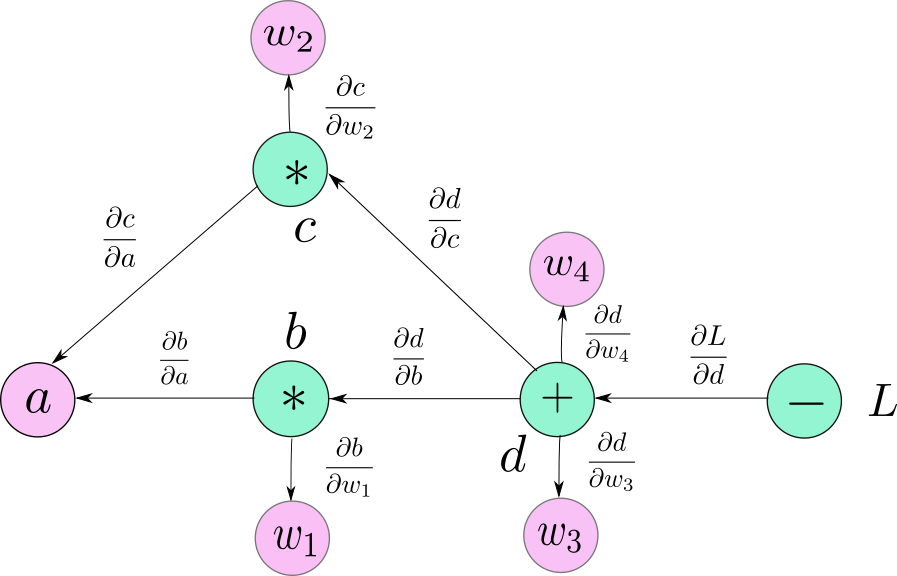

Our calculation will involve a number of discrete steps, each which create intermediate variables seen below:

$
\begin{align}
    b & = w_1 * a\\
    c & = w_2 * a\\
    d & = w_3*b + w_4*c\\
    L & = 10 -d
\end{align}
$

In order to calculate the total derivative of L with respect to say $w_1$ we use the chain rule

$$
\frac{dL}{dw_1} = \frac{\partial L}{\partial d}\frac{\partial d}{\partial b}\frac{\partial b}{\partial w_1}
$$

Using PyTorch the partial derivatives for each calculation are easily calculated for a wide variety of calculations and variable manipulations that we need for model building and programming. Furthermore, this is easily done with thousands of variables and/or manipulations at a time! Thanks PyTorch!

Lets take a look at how this can be done in practice. We start with defining some variables that we will need the derivatives with respect to by specifying `requires_grad = True` during creation.

In [13]:
#define variables (the chosen values here are arbitrary)
a = torch.tensor([2.], requires_grad=True)
w1 = torch.tensor([3.], requires_grad=True)
w2 = torch.tensor([1.], requires_grad=True)
w3 = torch.tensor([0.5], requires_grad=True)
w4 = torch.tensor([-2.], requires_grad=True)

#do the calculation
b = w1*a
c = w2*a
d = w3*b + w4*c
L = 10 - d

To calculate the derivatives we call `L.backward()`. After calling `backward()` the gradients are stored in the `.grad` attribute of each variable.

In [14]:
L.backward()
print(a.grad)
print(w4.grad)

tensor([0.5000])
tensor([-2.])


Note that we are calculating the gradient of $a$ and $w_4$ evaluated at their currently set values. In other words the grad attribute gives us

$$
\frac{dL}{da}\Big\rvert_{a = 2}
$$

<div class="alert alert-block alert-info">
    
**Task:** 
    Calculate (by hand) the quantity $\frac{dL}{dw_1}$, and check that this is consistent with the result given by `w1.grad`.
    
</div>

In [15]:
print(w1.grad) # Check that this is consistent with your analytical calculation

tensor([-1.])


Note that, if you redo the calculation a second time, the gradient will **accumulate**:

In [16]:
# redo the calculation a second time
b = w1*a
c = w2*a
d = w3*b + w4*c
L = 10 - d
# call backward to calculate the gradients a second time
L.backward()
# print gradient
print(w1.grad)

tensor([-2.])


If you want to avoid this, you can call `.grad.zero_()`

In [17]:
# zero the gradient
w1.grad.zero_()
# redo the calculation a third time
b = w1*a
c = w2*a
d = w3*b + w4*c
L = 10 - d
# call backward to calculate the gradients a third time
L.backward()
# print gradient
print(w1.grad)

tensor([-1.])


Note that you can also ask `pytorch` to temporarily stop tracking the gradients for certain operations:

In [18]:
with torch.no_grad():
    w1 = 2*w1

## Gradient descent

<div class="alert alert-block alert-info">
    
**Task:** 
    Now its your turn! Implement a gradient descent algortihm to minimize a simple test function below using autograd. Complete the implementation of the function `gradient_descent` below, to perform 100 iterations of gradient descent.

- implement the gradient descent algorithm using the above-mentioned features of pytorch
- record the values of `X0` as you go and generate a plot that shows how gradient descent travels through input space
- given the form of `test_function`, which value do you expect `X0` to converge to?
- redo the plot for 3 different values of the step size `alpha` [0.005, 0.1, 1.0 ]
    
</div>

In [32]:
def test_function(X):
    """
    Function to be optimized.
    
    Input: X, a pytorch tensor of shape (2,)
    Output: a single scalar
    """
    return (X[0] - 0.5)**2 + X[1]**2

def gradient_descent(X0, function, alpha=0.1, n_iterations=100):
    """
    Performs 100 iterations of gradient descent
    
    Inputs:
    X0: a pytorch tensor to be modified in-place by the gradient descent algorithm
    function: a callable, that takes X0 as input
    alpha: step size for the gradient descent algorithm
    n_iterations: number of iterations of gradient descent
    
    Returns:
    history_X: array of values of X
    history_f: array of values of f
    """
    history_X = []
    history_f = []
    for iteration in range(n_iterations): # iterations of gradient descent
        f = function(X0)
        
        # Your code that modifies X0 in-place here
        # ...
        f.backward()
        with torch.no_grad():
            X0 -= alpha*X0.grad
        X0.grad.zero_()
        
        # Keep a copy in history (do not modify these lines)
        history_X.append( X0.detach().numpy().copy() ) 
        history_f.append( f.detach().numpy().copy() )
        
    return np.array(history_X), np.array(history_f)

(-1.0, 1.0)

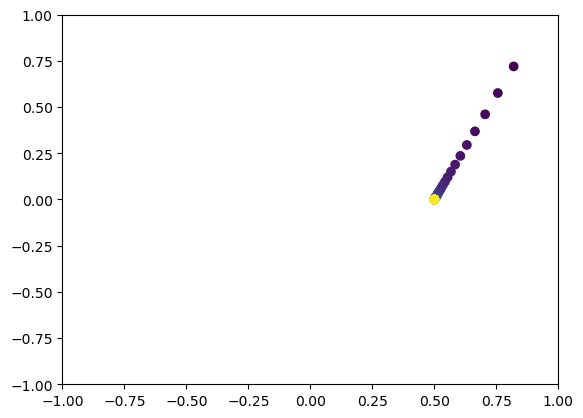

In [33]:
# Test your code by executing the code below
X0 = torch.tensor([0.9,0.9], requires_grad=True)
alpha = 0.1

history_X, history_f = gradient_descent( X0, test_function, alpha)

# Plot the trajectory of the points
plt.scatter( history_X[:,0], history_X[:,1], c=np.arange(len(history_X)))
plt.xlim(-1, 1)
plt.ylim(-1, 1)

## Accelerator example
Now we will use gradient descent to optimize the focusing strength of a single quadrupole magnet in a single dimension. This is a very simple optimization problem (which as a result does not need gradient descent to solve), but is useful as an example for optimization.

To do this using gradient descent (and backwards differentiation) we will use the cheetah library (https://github.com/desy-ml/cheetah/) which contains particle tracking code written in PyTorch. We start by creating a beam with a specific set of beam parameters and then also define the beamline which we will propagate the beam through.

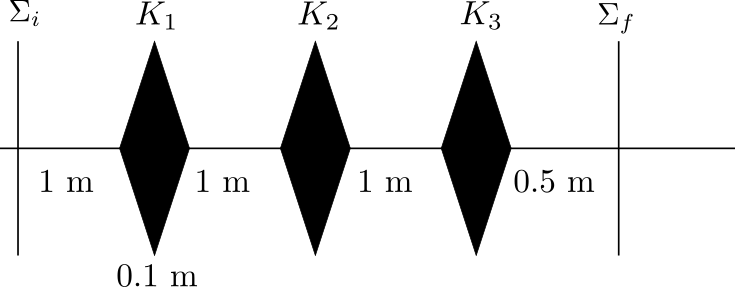

In [41]:
from cheetah.particles import ParameterBeam
from cheetah.accelerator import Drift, Quadrupole, Segment

incoming_beam = ParameterBeam.from_twiss(
    beta_x=torch.tensor(5.0), 
    alpha_x=torch.tensor(0.0),
    emittance_x=torch.tensor(1e-8)
)

beamline = Segment(
    [
        Drift(length=torch.tensor(1.0)),
        Quadrupole(name="Q1",length=torch.tensor(0.1)),
        Drift(length=torch.tensor(1.0))
    ]
)

def calculate_x_beamsize(K):
    # set beamline parameters
    beamline.Q1.k1 = K
    
    # track the beam
    final_beam = beamline.track(incoming_beam)
    
    # return the beam size in x (in mm)
    return final_beam.sigma_x * 1e3


In [42]:
#example usage
K = torch.tensor([1.0], requires_grad = True)
print(K.requires_grad)
size = calculate_x_beamsize(K)
print("Final beamsize in x: ", size)
size.backward()
print("Gradient of the beamsize with respect to K", K.grad)

True
Final beamsize in x:  tensor([0.2191], grad_fn=<MulBackward0>)
Gradient of the beamsize with respect to K tensor([-0.0234])


### Solve the optimization problem

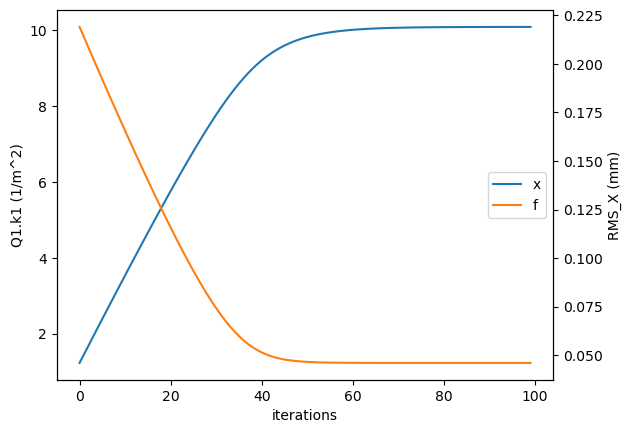

In [58]:
X0 = torch.tensor([1.0], requires_grad=True)
alpha = 10.0

history_X, history_f = gradient_descent(X0, calculate_x_beamsize, alpha)

# Plot the trajectory of the points
fig, ax = plt.subplots()
line1, = ax.plot(history_X[:, 0], label="x", color="C0")
axb = ax.twinx()
line2, = axb.plot(history_f[:, 0], label="f", color="C1")
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels,loc="center right")
ax.set_xlabel("iterations")
ax.set_ylabel("Q1.k1 (1/m^2)")
axb.set_ylabel("RMS_X (mm)");

## Optimize a quadrupole triplet using gradient descent

<div class="alert alert-block alert-info">
    
**Task:**
    Use gradient descent to optimize the quadrupole strengths of a quadrupole triplet to minimize the total beamsize defined here as ($\sqrt{\sigma_x**2 * \sigma_y**2}$) in mm. Plot the quadrupole strengths and objective function value as a function of iteration number.
        
</div>

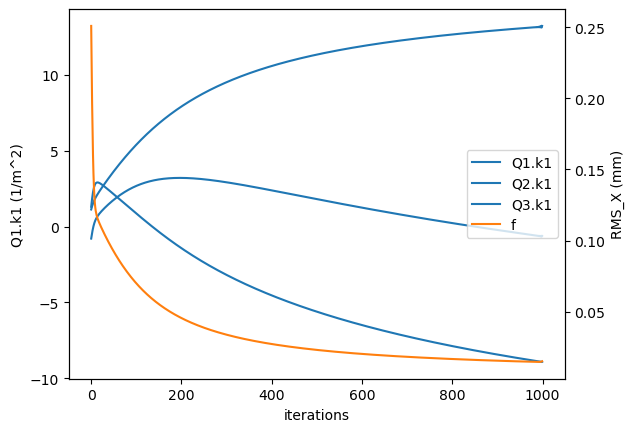

In [69]:
from cheetah.particles import ParameterBeam
from cheetah.accelerator import Drift, Quadrupole, Segment

incoming_beam = ParameterBeam.from_twiss(
    beta_x=torch.tensor(5.0), 
    alpha_x=torch.tensor(0.0),
    emittance_x=torch.tensor(1e-8)
)

beamline = Segment(
    [
        Drift(length=torch.tensor(1.0)),
        Quadrupole(name="Q1",length=torch.tensor(0.1)),
        Drift(length=torch.tensor(1.0)),
        Quadrupole(name="Q2",length=torch.tensor(0.1)),
        Drift(length=torch.tensor(1.0)),
        Quadrupole(name="Q3",length=torch.tensor(0.1)),
        Drift(length=torch.tensor(1.0))
    ]
)

def calculate_beamsize(K):
    # set beamline parameters
    beamline.Q1.k1 = K[0]
    beamline.Q2.k1 = K[1]
    beamline.Q3.k1 = K[2]
    
    # track the beam
    final_beam = beamline.track(incoming_beam)
    
    # return the beam size in x (in mm)
    return (final_beam.sigma_x**2 + final_beam.sigma_y**2).sqrt() * 1e3


X0 = torch.tensor([1.0,-1.0,1.0], requires_grad=True)
alpha = 5.0

history_X, history_f = gradient_descent(
    X0, calculate_beamsize, alpha, n_iterations=1000
)

fig, ax = plt.subplots()
lines = []
for i in range(3):
    line1, = ax.plot(history_X[:, i], label=f"Q{i+1}.k1", color="C0")
    lines += [line1]
axb = ax.twinx()
line2, = axb.plot(history_f, label="f", color="C1")
lines += [line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels,loc="center right")
ax.set_xlabel("iterations")
ax.set_ylabel("Q1.k1 (1/m^2)")
axb.set_ylabel("RMS_X (mm)");

## Gradient descent with numerical differentiation

<div class="alert alert-block alert-success">
    
**Homework:**
    Try to minimize again the beam size, but using numerical differentiation instead of autograd. In this case, you will **not** call the `.backward` and `.grad` functions, but instead you will need to calculate the gradient numerically: vary in the input `K` by `h=1.e-4` in each direction, in order to compute the gradient of `beam_size`.
    
(Note that, because we do not call `.backward`, we also do not need to set `requires_grad = True`.)
    
Does the algorithm reach the same final value, for the beamsize?
</div>

In [ ]:
def gradient_descent_nd(X0, function, alpha=0.1, n_iterations=100):
    """
    Performs n_iterations iterations of gradient descent, 
    with numerical differentiation
    
    Inputs:
    X0: a pytorch tensor to be modified in-place by the gradient descent algorithm
    function: a callable, that takes X0 as input
    alpha: step size for the gradient descent algorithm
    n_iterations: number of iterations of gradient descent
    
    Returns:
    history_X: array of values of X
    history_f: array of values of f
    """
    history_X = []
    history_f = []
    for iteration in range(n_iterations): # iterations of gradient descent
        f = function(X0)
        
        # Your code that modifies X0 in-place here
        # ...
        
        # Keep a copy in history (do not modify these lines)
        history_X.append( X0.detach().numpy().copy() ) 
        history_f.append( f.detach().numpy().copy() )
        
    return np.array(history_X), np.array(history_f)

In [ ]:
# Your code here: call `gradient_descent_nd` and plot the corresponding `history_f`

**Your answer here:** (Does the algorithm reach the same value of `K`?)

## Gradient descent with noise

The function below emulates noise in the beam size measurement. 
Call this function several times for a given value of `K`. 

In [ ]:
def beamsize_with_noise(K):
    return beamsize(K, noise=2.e-5)

In [ ]:
# Call this function several times to get a sense of how much 
# the noise is changing the result
beamsize_with_noise(K)

<div class="alert alert-block alert-success">
    
**Homework:**
    Now perform the same optimization as before, but on the function `beam_size_with_noise` instead of `beam_size`. Does the analytical gradient descent reach approximately the same final value of the beamsize as before? Does the version of gradient descent with finite difference reach the same value too? Why? (Plot the history of the beamsize in both cases.) 
</div>

In [ ]:
# Your code here
# ...

**Your answer here:** (Does the analytical gradient descent reach approximately the same final value of the beamsize as before? Does the version of gradient descent with finite difference reach the same value too? Why?)